### Import libraries

In [8]:
import keras
from keras import layers
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from IPython.display import Image

from tensorflow.keras.layers import Input, Conv2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

### Needed functions

In [9]:
def noising(images, mean=0.05, sigma=0.1):
    guass_noise = np.random.normal(mean, sigma, images.shape)
    noisy_images = images + guass_noise

    # Make sure the values are still between 0 and 1
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

In [10]:
def noising_tensors(images, mean=0.05, sigma=0.1):
    noisy = tf.random.normal(shape=tf.shape(images), mean=mean, stddev=sigma)
    return images + noisy

In [42]:
def compression_ratio(o, c):
    return c.nbytes / o.nbytes

### 1. Loading RGB images (cifar10 dataset)

In [12]:
# Load dataset
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### 2. Use auto encoder in a split format as an image denoiser

In [13]:
# Reshape the data to fit the model
x_train_2 = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_2 = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train_2.shape)
print(x_test_2.shape)

(50000, 3072)
(10000, 3072)


### 2.1. Noised original images

In [14]:
# Add noise to the images
x_train_noised_2 = noising(x_train_2)

# This is the size of our encoded representations
encoding_dim = 900

# This is our input image
input_img = keras.Input(shape=(3072,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(3072, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

# Encoded 900 input
encoded_input = keras.Input(shape=(encoding_dim,))

# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
autoencoder.fit(x_train_noised_2, x_train_2,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_split=0.1)

Epoch 1/25
176/176 [==============================] - 18s 97ms/step - loss: 0.6324 - val_loss: 0.6109
Epoch 2/25
176/176 [==============================] - 16s 94ms/step - loss: 0.6045 - val_loss: 0.5991
Epoch 3/25
176/176 [==============================] - 17s 94ms/step - loss: 0.5967 - val_loss: 0.5947
Epoch 4/25
176/176 [==============================] - 16s 90ms/step - loss: 0.5905 - val_loss: 0.5927
Epoch 5/25
176/176 [==============================] - 16s 92ms/step - loss: 0.5872 - val_loss: 0.5850
Epoch 6/25
176/176 [==============================] - 19s 105ms/step - loss: 0.5842 - val_loss: 0.5836
Epoch 7/25
176/176 [==============================] - 17s 99ms/step - loss: 0.5813 - val_loss: 0.5803
Epoch 8/25
176/176 [==============================] - 16s 92ms/step - loss: 0.5793 - val_loss: 0.5801
Epoch 9/25
176/176 [==============================] - 17s 99ms/step - loss: 0.5785 - val_loss: 0.5785
Epoch 10/25
176/176 [==============================] - 19s 107ms/step - loss: 0.5

In [16]:
x_test_noised_2 = noising(x_test_2)
encoded_imgs_2_1 = encoder.predict(x_test_noised_2)
decoded_imgs_2_1 = decoder.predict(encoded_imgs_2_1)

313/313 [==============================] - 1s 4ms/step


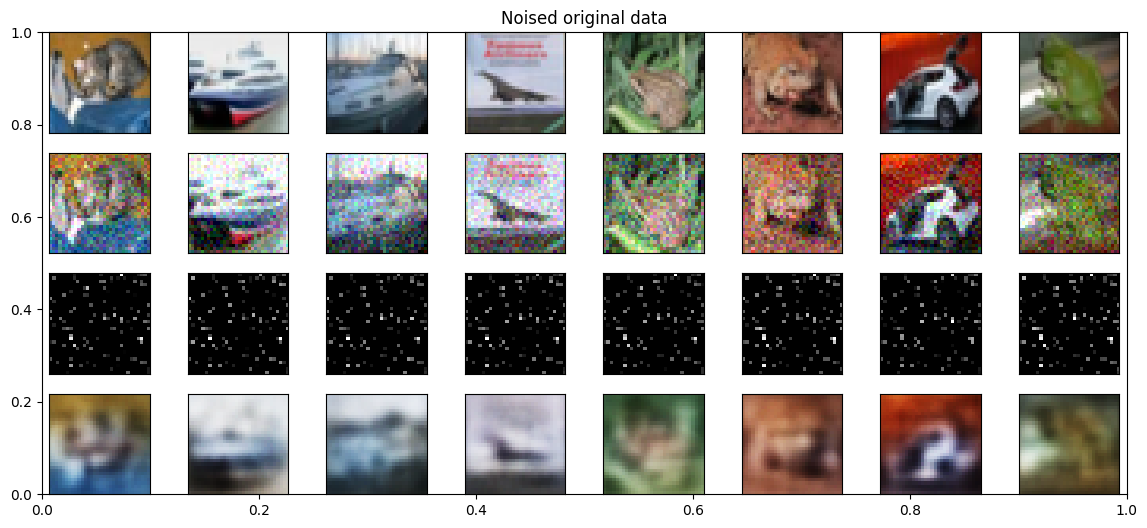

In [17]:
n = 8

plt.figure(figsize=(14, 6))
plt.title('Noised original data')
for i in range(n):
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(x_test_2[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(x_test_noised_2[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(encoded_imgs_2_1[i].reshape(30, 30))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(decoded_imgs_2_1[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 2.2. Noised encoded images

In [18]:
# This is the size of our encoded representations
encoding_dim = 900

# This is our input image
input_img = keras.Input(shape=(3072,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# Add Gaussian noise to the encoded data
encoded_noisy = layers.Lambda(noising_tensors)(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(3072, activation='sigmoid')(encoded_noisy)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded_noisy)

# Encoded 900 input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [19]:
autoencoder.fit(x_train_2, x_train_2,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_split=0.1)

Epoch 1/25
176/176 [==============================] - 16s 88ms/step - loss: 0.6217 - val_loss: 0.5971
Epoch 2/25
176/176 [==============================] - 15s 88ms/step - loss: 0.5895 - val_loss: 0.5869
Epoch 3/25
176/176 [==============================] - 15s 87ms/step - loss: 0.5818 - val_loss: 0.5811
Epoch 4/25
176/176 [==============================] - 16s 88ms/step - loss: 0.5782 - val_loss: 0.5787
Epoch 5/25
176/176 [==============================] - 16s 89ms/step - loss: 0.5757 - val_loss: 0.5769
Epoch 6/25
176/176 [==============================] - 16s 88ms/step - loss: 0.5738 - val_loss: 0.5750
Epoch 7/25
176/176 [==============================] - 15s 88ms/step - loss: 0.5725 - val_loss: 0.5734
Epoch 8/25
176/176 [==============================] - 15s 87ms/step - loss: 0.5715 - val_loss: 0.5728
Epoch 9/25
176/176 [==============================] - 15s 88ms/step - loss: 0.5704 - val_loss: 0.5721
Epoch 10/25
176/176 [==============================] - 15s 87ms/step - loss: 0.569

In [20]:
encoded_imgs_2_2 = encoder.predict(x_test_2)
decoded_imgs_2_2 = decoder.predict(encoded_imgs_2_2)

313/313 [==============================] - 2s 5ms/step


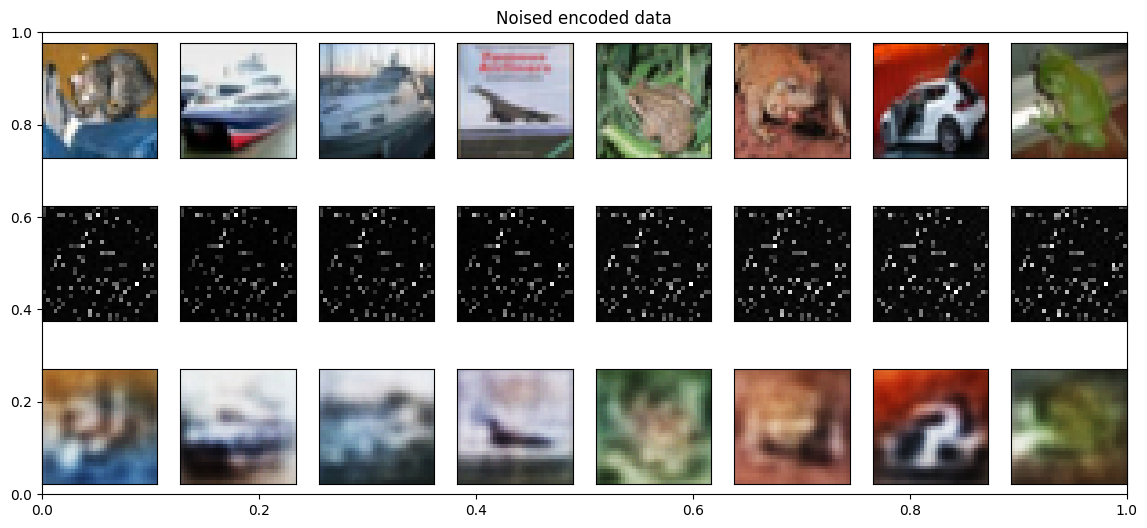

In [21]:
n = 8

plt.figure(figsize=(14, 6))
plt.title('Noised encoded data')
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_2[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs_2_2[i].reshape(30, 30))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs_2_2[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 3. Visualize difference between 2.1 and 2.2

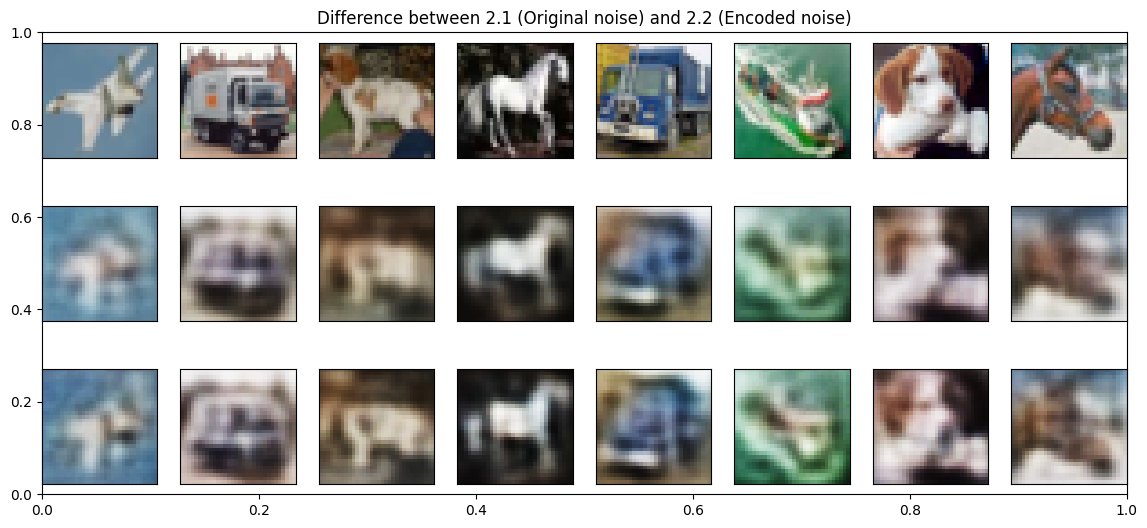

In [22]:
n = 8

plt.figure(figsize=(14, 6))
plt.title('Difference between 2.1 (Original noise) and 2.2 (Encoded noise)')
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_2[i+10].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs_2_1[i+10].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs_2_2[i+10].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### 4.1. Comparison between denoising using PCA vs Auto encoder

In [23]:
# Reshape the data to fit the model
x_train_3 = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_3 = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train_3.shape)
print(x_test_3.shape)

x_train_noised_3 = noising(x_train_3)
x_test_noised_3 = noising(x_test_3)

(50000, 3072)
(10000, 3072)


In [24]:
# Apply PCA
pca = PCA(0.95)
pca.fit(x_train_3)

PCA(n_components=0.95)

In [25]:
x_test_pca = pca.transform(x_test_noised_3)

# Denoise images using  PCA
x_test_denoised_pca = pca.inverse_transform(x_test_pca)

In [26]:
# Define the autoencoder architecture
input_img = Input(shape=(3072,))
encoded = Dense(1024, activation='relu')(input_img)
decoded = Dense(3072, activation='sigmoid')(encoded)

# Create a new autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(x_train_noised_3, x_train_3,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_split=0.1)

# Denoise images using autoencoder
x_test_denoised_autoencoder = autoencoder.predict(x_test_noised_3)

Epoch 1/10
176/176 [==============================] - 22s 118ms/step - loss: 0.6302 - val_loss: 0.6094
Epoch 2/10
176/176 [==============================] - 20s 115ms/step - loss: 0.6025 - val_loss: 0.5978
Epoch 3/10
176/176 [==============================] - 20s 116ms/step - loss: 0.5940 - val_loss: 0.5911
Epoch 4/10
176/176 [==============================] - 20s 115ms/step - loss: 0.5892 - val_loss: 0.5973
Epoch 5/10
176/176 [==============================] - 20s 115ms/step - loss: 0.5854 - val_loss: 0.5839
Epoch 6/10
176/176 [==============================] - 20s 116ms/step - loss: 0.5825 - val_loss: 0.5824
Epoch 7/10
176/176 [==============================] - 20s 111ms/step - loss: 0.5798 - val_loss: 0.5794
Epoch 8/10
176/176 [==============================] - 19s 110ms/step - loss: 0.5782 - val_loss: 0.5780
Epoch 9/10
176/176 [==============================] - 19s 110ms/step - loss: 0.5773 - val_loss: 0.5795
Epoch 10/10
313/313 [==============================] - 2s 7ms/step


In [27]:
# Reshape the denoised images to their original shape
x_test_denoised_pca = x_test_denoised_pca.reshape((len(x_test_denoised_pca), 32, 32, 3))
x_test_denoised_autoencoder = x_test_denoised_autoencoder.reshape((len(x_test_denoised_autoencoder), 32, 32, 3))

#### Subjective measure
- PCA is better.

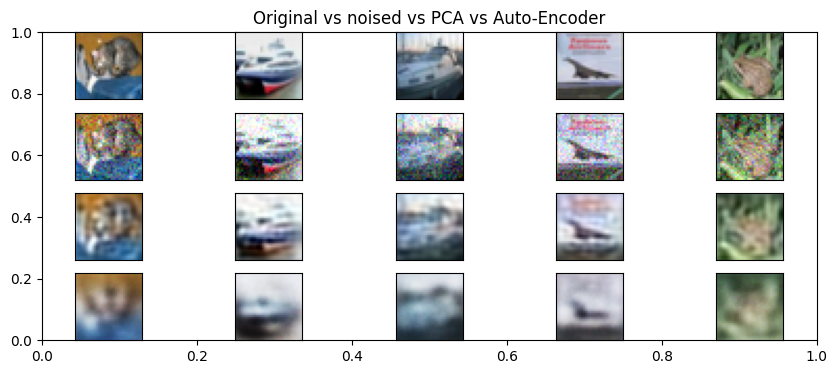

In [36]:
# Display some of the original, noised, and denoised images
plt.figure(figsize=(10, 4))
plt.title("Original vs noised vs PCA vs Auto-Encoder")
for i in range(5):
    # Original images
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(x_test_3[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Noised images
    ax = plt.subplot(4, 5, i + 1 + 5)
    plt.imshow(x_test_noised_3[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised images using PCA
    ax = plt.subplot(4, 5, i + 1 + 10)
    plt.imshow(x_test_denoised_pca[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Denoised images using autoencoder
    ax = plt.subplot(4, 5, i + 1 + 15)
    plt.imshow(x_test_denoised_autoencoder[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#### Objective measure

In [64]:
x_test_denoised_pca.nbytes > x_test_noised_3.nbytes

False

In [67]:
pca_ratio = (x_test_denoised_pca.nbytes / x_test.nbytes) * 100
autoencoder_ratio = (x_test_denoised_autoencoder.nbytes / x_test.nbytes) * 100

print(f'Compression ratio of PCA ----------------> {pca_ratio}%')
print(f'Compression ratio of Autoencoder --------> {autoencoder_ratio}%')


Compression ratio of PCA ----------------> 100.0%
Compression ratio of Autoencoder --------> 50.0%


In [59]:
i = 'abc'
i.nbytes

AttributeError: 'str' object has no attribute 'nbytes'

In [38]:
(x_train.nbytes)

614400000

### 4.2. Using CNN instead of Fully connected layer

In [30]:
def autoEncoderCNN(x_train, x_test):
    x_train_noised = noising(x_train)
    input_images = Input(shape=x_train[0].shape)

    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_images)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    # AutoEncoder
    autoencoder = Model(input_images, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    # Train the autoencoder
    autoencoder.fit(x_train_noised, 
                    x_train,
                    epochs=5,
                    batch_size=256,
                    shuffle=True,
                    validation_split=0.1) # use 20% of the data for validation
                    
    # Use the autoencoder to denoise the test images
    x_test_noised = noising(x_test)
    x_test_noised = x_test_noised.reshape((len(x_test_noised), 32, 32, 3))
    x_test_denoised = autoencoder.predict(x_test_noised)
                    
    return x_test_noised, x_test_denoised

In [31]:
x_test_noised, x_test_denoised = autoEncoderCNN(x_train, x_test)

Epoch 1/5
176/176 [==============================] - 62s 340ms/step - loss: 0.5791 - val_loss: 0.5614
Epoch 2/5
176/176 [==============================] - 61s 344ms/step - loss: 0.5582 - val_loss: 0.5590
Epoch 3/5
176/176 [==============================] - 60s 339ms/step - loss: 0.5564 - val_loss: 0.5574
Epoch 4/5
176/176 [==============================] - 60s 341ms/step - loss: 0.5550 - val_loss: 0.5574
Epoch 5/5
313/313 [==============================] - 5s 15ms/step


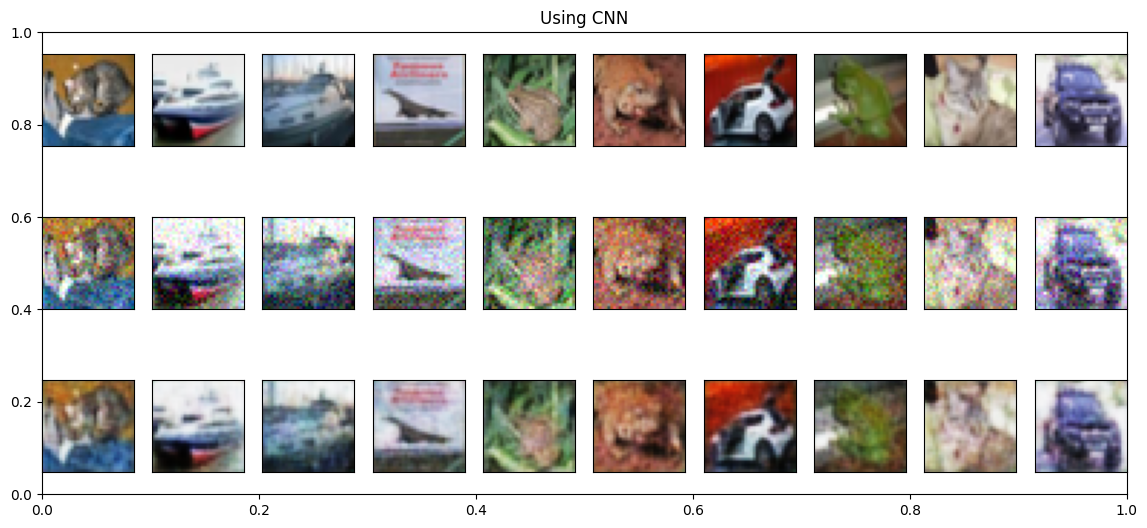

In [32]:
n = 10

plt.figure(figsize=(14, 6))
plt.title('Using CNN')
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noised[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_denoised[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### 5. Results report

- Noised original vs Noised encoded ---> Noised encoded is slightly better.

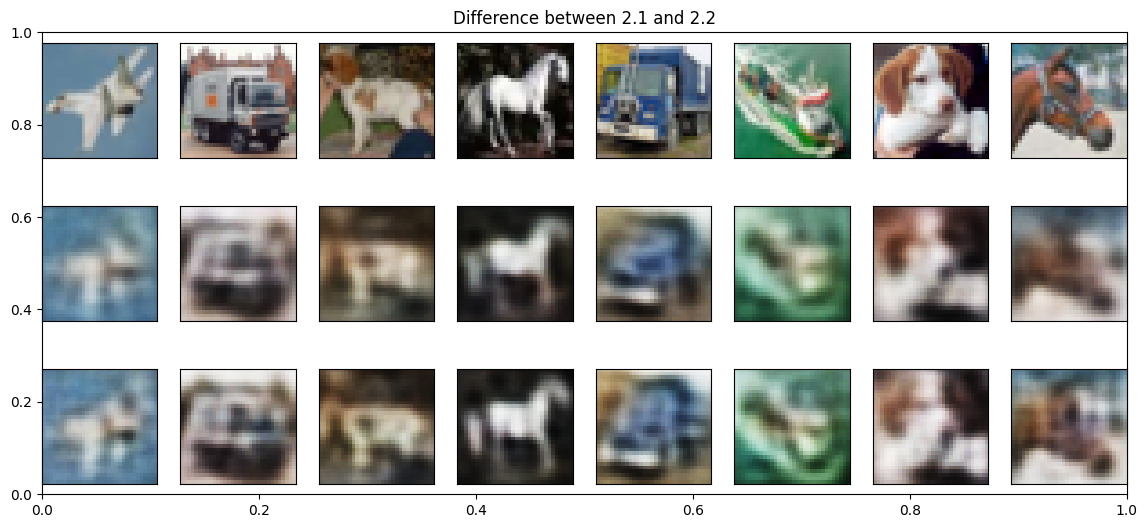

In [33]:
img = Image(filename="vs.png")
display(img)

- PCA vs Autoencoder -------------------> PCA is better. 

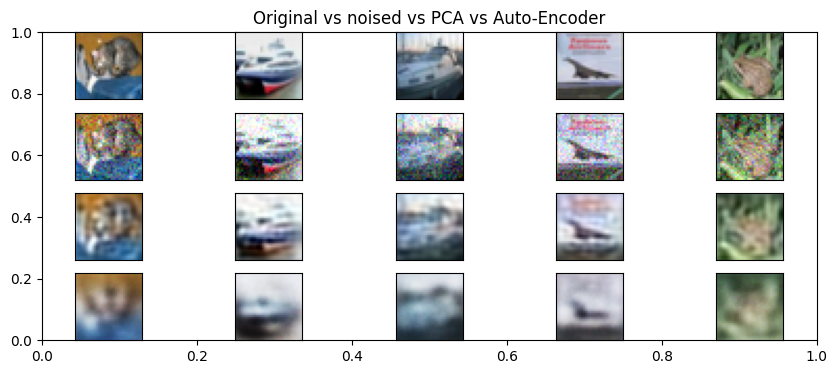

In [34]:
img = Image(filename="pca.png")
display(img)

- CNN ------------------------------------> Great results and best of all

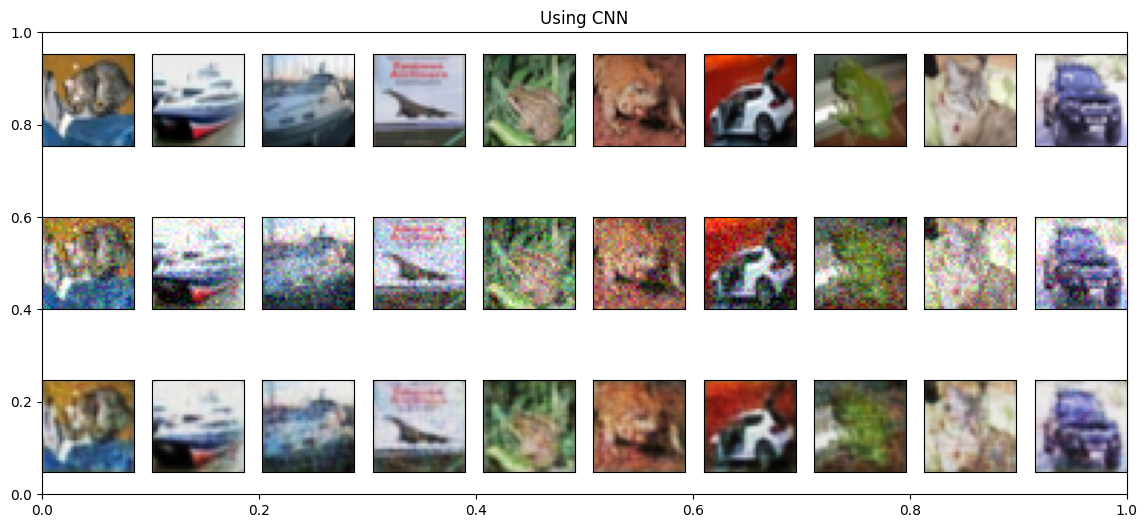

In [35]:
img = Image(filename="cnn.png")
display(img)